<a href="https://colab.research.google.com/github/educanto/reinforcement-learning/blob/main/RobotReach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [13]:
!pip install panda-gym
!pip install numpngw
!pip install gym==0.25.2
!pip install stable-baselines3

## Import necessary modules

In [14]:
import gymnasium as gym
import panda_gym

from numpngw import write_apng
import imageio
from IPython.display import Image
import PIL.Image

from stable_baselines3 import DDPG, TD3
from stable_baselines3.td3.policies import MultiInputPolicy
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.her import HerReplayBuffer
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.monitor import Monitor

import matplotlib.pyplot as plt

import numpy as np
import os

import warnings
warnings.filterwarnings('ignore')

## Get environment information

In the Robot Reach environment the robot must place its end-effector at a target position. By default, the environment is terminated when the objective is reached or truncated after 50 steps. The reward is -1 for each time step.

https://arxiv.org/abs/2106.13687

https://panda-gym.readthedocs.io/en/latest/usage/environments.html

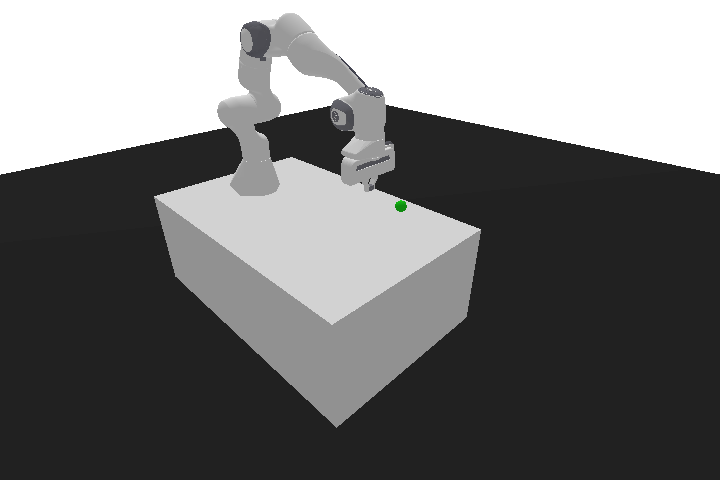

In [15]:
env = gym.make("PandaReach-v3", render_mode="rgb_array")

env.reset()

PIL.Image.fromarray(env.render())

In [16]:
env.spec

EnvSpec(id='PandaReach-v3', entry_point='panda_gym.envs:PandaReachEnv', reward_threshold=None, nondeterministic=False, max_episode_steps=50, order_enforce=True, autoreset=False, disable_env_checker=False, apply_api_compatibility=False, kwargs={'reward_type': 'sparse', 'control_type': 'ee', 'render_mode': 'rgb_array'}, namespace=None, name='PandaReach', version=3, additional_wrappers=(), vector_entry_point=None)

In [17]:
env.observation_space

Dict('achieved_goal': Box(-10.0, 10.0, (3,), float32), 'desired_goal': Box(-10.0, 10.0, (3,), float32), 'observation': Box(-10.0, 10.0, (6,), float32))

In [18]:
env.action_space

Box(-1.0, 1.0, (3,), float32)

## Callback class

In [19]:
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` episodes)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int) Number of episodes between each check.
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contain the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """

    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super().__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, "best_model")
        self.best_mean_reward = -np.inf
        self.episode_count = 0

    def _init_callback(self) -> None:
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        return True

    def _on_rollout_end(self) -> bool:
        self.episode_count += 1

        if self.episode_count % self.check_freq == 0:

            x, y = ts2xy(load_results(self.log_dir), "episodes")
            if len(x) > 0:
                mean_reward = np.mean(y[-self.check_freq:])
                if self.verbose > 0:
                    print(f"\nNum episodes: {self.episode_count}")
                    print(f"Num timesteps: {self.n_calls}")
                    print(f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}")

                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    if self.verbose > 0:
                        print(f"Saving new best model to {self.save_path}.zip")
                    self.model.save(self.save_path)
        return True

## Create agent to learn

**DDPG algorithm**

In [20]:
env = gym.make("PandaReach-v3", render_mode="rgb_array")

# ---

log_dir_ddpg = "/tmp/gym/ddpg"
os.makedirs(log_dir_ddpg, exist_ok=True)

# Logs will be saved in log_dir/monitor.csv
log_env = Monitor(env, log_dir_ddpg)

check_freq = 10
callback = SaveOnBestTrainingRewardCallback(check_freq=check_freq, log_dir=log_dir_ddpg)

# ---

total_timesteps = 7000

noise_stddev = 0.2
n_actions = env.action_space.shape[-1]
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=noise_stddev * np.ones(n_actions))

model = DDPG("MultiInputPolicy",
             DummyVecEnv([lambda: log_env]),
             train_freq=(1, "episode"),
             learning_rate=1e-03,
             batch_size=512,
             buffer_size=100000,
             replay_buffer_class=HerReplayBuffer,
             policy_kwargs=dict(net_arch=[128]),
             learning_starts=100,
             tau=0.005,
             gamma=0.99,
             action_noise=action_noise,
             device='auto',
             verbose=2)

model.learn(total_timesteps=total_timesteps, log_interval=50, callback=callback)

Using cpu device

Num episodes: 10
Num timesteps: 451
Best mean reward: -inf - Last mean reward per episode: -45.00
Saving new best model to /tmp/gym/ddpg/best_model.zip

Num episodes: 20
Num timesteps: 915
Best mean reward: -45.00 - Last mean reward per episode: -46.30

Num episodes: 30
Num timesteps: 1333
Best mean reward: -45.00 - Last mean reward per episode: -41.60
Saving new best model to /tmp/gym/ddpg/best_model.zip

Num episodes: 40
Num timesteps: 1522
Best mean reward: -41.60 - Last mean reward per episode: -18.20
Saving new best model to /tmp/gym/ddpg/best_model.zip
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 33.2     |
|    ep_rew_mean     | -32.8    |
|    success_rate    | 0.38     |
| time/              |          |
|    episodes        | 50       |
|    fps             | 46       |
|    time_elapsed    | 35       |
|    total_timesteps | 1660     |
| train/             |          |
|    actor_loss      | 2.94     |
|    crit

**TD3 algorithm**

In [21]:
env = gym.make("PandaReach-v3", render_mode="rgb_array")

# ---

log_dir_td3 = "/tmp/gym/td3"
os.makedirs(log_dir_td3, exist_ok=True)

# Logs will be saved in log_dir/monitor.csv
log_env = Monitor(env, log_dir_td3)

check_freq = 10
callback = SaveOnBestTrainingRewardCallback(check_freq=check_freq, log_dir=log_dir_td3)

# ---

total_timesteps = 7000

noise_stddev = 0.2
n_actions = env.action_space.shape[-1]
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=noise_stddev * np.ones(n_actions))

model = TD3("MultiInputPolicy",
             DummyVecEnv([lambda: log_env]),
             train_freq=(1, "episode"),
             learning_rate=1e-03,
             batch_size=512,
             buffer_size=100000,
             replay_buffer_class=HerReplayBuffer,
             policy_kwargs=dict(net_arch=[128]),
             learning_starts=100,
             tau=0.005,
             gamma=0.99,
             action_noise=action_noise,
             device='auto',
             verbose=2)

model.learn(total_timesteps=total_timesteps, log_interval=50, callback=callback)

Using cpu device

Num episodes: 10
Num timesteps: 463
Best mean reward: -inf - Last mean reward per episode: -46.20
Saving new best model to /tmp/gym/td3/best_model.zip

Num episodes: 20
Num timesteps: 963
Best mean reward: -46.20 - Last mean reward per episode: -50.00

Num episodes: 30
Num timesteps: 1463
Best mean reward: -46.20 - Last mean reward per episode: -50.00

Num episodes: 40
Num timesteps: 1893
Best mean reward: -46.20 - Last mean reward per episode: -42.80
Saving new best model to /tmp/gym/td3/best_model.zip
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 43.2     |
|    ep_rew_mean     | -43.1    |
|    success_rate    | 0.16     |
| time/              |          |
|    episodes        | 50       |
|    fps             | 57       |
|    time_elapsed    | 37       |
|    total_timesteps | 2161     |
| train/             |          |
|    actor_loss      | 2.56     |
|    critic_loss     | 0.203    |
|    learning_rate   | 0.001   

## Learning results

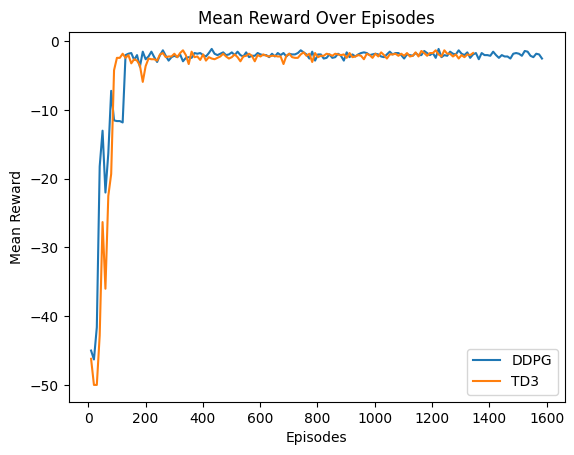

In [22]:
x, y_ddpg = ts2xy(load_results(log_dir_ddpg), "episodes")
x, y_td3 = ts2xy(load_results(log_dir_td3), "episodes")

mean_rewards_ddpg = []
mean_rewards_td3 = []
n = 0
for i in range(1, 1+ max(len(y_ddpg),len(y_td3))):
    if i % check_freq == 0:
        if i >= len(y_ddpg):
            mean_rewards_ddpg.append(None)
        else:
            mean_reward_ddpg = np.mean(y_ddpg[n*check_freq:(n+1)*check_freq])
            mean_rewards_ddpg.append(mean_reward_ddpg)

        if i >= len(y_td3):
            mean_rewards_td3.append(None)
        else:
            mean_reward_td3 = np.mean(y_td3[n*check_freq:(n+1)*check_freq])
            mean_rewards_td3.append(mean_reward_td3)

        n += 1

episode_counter = np.linspace(check_freq, max(len(y_ddpg),len(y_td3)), int(max(len(y_ddpg),len(y_td3))/check_freq))

plt.plot(episode_counter, mean_rewards_ddpg, label='DDPG')
plt.plot(episode_counter, mean_rewards_td3, label='TD3')

plt.title("Mean Reward Over Episodes")
plt.xlabel("Episodes")
plt.ylabel("Mean Reward")

plt.legend()
plt.show()

## Save model

In [23]:
# Callback already saves the best model
# model.save("ddpg_reach")

## Load model

In [24]:
model_DDPG = DDPG.load("/tmp/gym/ddpg/best_model.zip", env=env)
model_TD3 = TD3.load("/tmp/gym/td3/best_model.zip", env=env)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


## Evaluate model

In [25]:
mean_reward, std_reward = evaluate_policy(model_DDPG, env, n_eval_episodes=10)

print("DDPG model:")
print(f"Mean reward: {mean_reward}, Std reward: {std_reward}")

mean_reward, std_reward = evaluate_policy(model_TD3, env, n_eval_episodes=10)

print("TD3 model:")
print(f"Mean reward: {mean_reward}, Std reward: {std_reward}")

DDPG model:
Mean reward: -1.7, Std reward: 0.9000000000000001
TD3 model:
Mean reward: -1.7, Std reward: 1.004987562112089


## Simulation over somes episodes

In [26]:
def simulate(model, env_name, episodes, gif_name):

    images = []

    env = gym.make(env_name, render_mode="rgb_array")

    for episode in range(episodes):

        state, _ = env.reset()
        images.append(env.render())

        for i in range(50):
            action = model.predict(state)[0]

            state, reward, terminated, truncated, info = env.step(action)
            images.append(env.render())

            if terminated or truncated:
                break

    env.close()

    imageio.mimsave(gif_name, images, duration=200/1000, loop=0)

    write_apng("anim.png", images, delay=200)
    return Image(filename="anim.png")

**DDPG**

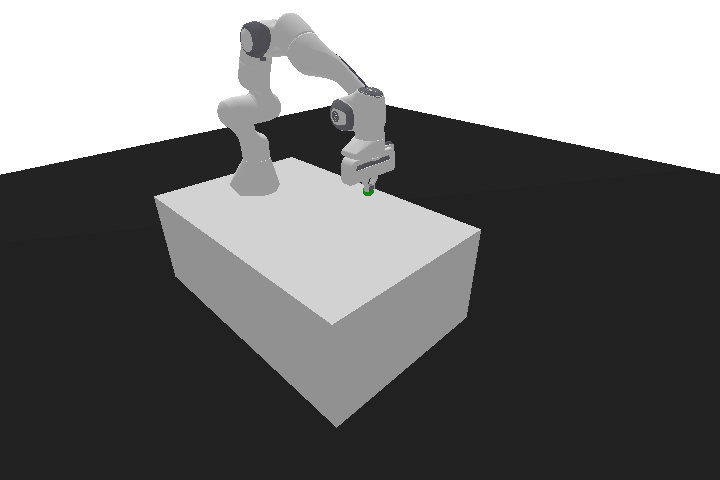

In [27]:
simulate(model_DDPG, "PandaReach-v3", 10, "ddpg.gif")

**TD3**

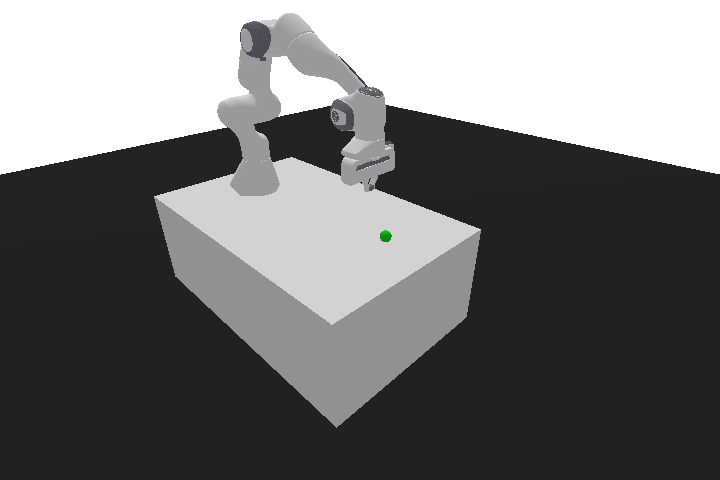

In [28]:
simulate(model_TD3, "PandaReach-v3", 10, "td3.gif")